# Calculating Zero Beta Portfolio #

### Yearly (252 days) Rebalancing ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from scipy.optimize import minimize

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [3]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500

sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

In [4]:
# Call the betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

betas_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-26,1.152338,1.166591,0.939661,1.107909,1.171802,1.195408,1.118394,1.022190,1.249073,0.500243,...,0.774610,1.074109,1.721360,0.452539,1.016533,0.972569,1.059763,0.807060,1.560041,0.972071
2016-02-29,1.152037,1.166537,0.939727,1.107902,1.172187,1.194066,1.117375,1.022437,1.245565,0.503666,...,0.773613,1.073822,1.721667,0.454845,1.016626,0.972044,1.058855,0.806179,1.559724,0.973369
2016-03-01,1.150741,1.162678,0.947581,1.112593,1.175925,1.193401,1.110462,1.024013,1.236025,0.497681,...,0.777704,1.062449,1.713627,0.450288,1.021999,0.972575,1.048272,0.806323,1.535979,0.983824
2016-03-02,1.158599,1.180528,0.960185,1.097906,1.188461,1.198640,1.095517,1.023562,1.263279,0.479161,...,0.785904,1.064054,1.690229,0.431224,1.007240,0.958904,1.084445,0.788765,1.511657,0.987076
2016-03-03,1.160238,1.179626,0.956580,1.096988,1.187307,1.200510,1.097509,1.019410,1.264678,0.478531,...,0.785601,1.067161,1.689917,0.431229,1.010486,0.958354,1.081805,0.788025,1.520338,0.983627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.876024,1.037784,0.194117,0.161045,1.152206,1.811338,0.440483,0.369979,1.321824,0.050615,...,0.659141,0.629752,0.945839,0.030221,0.178952,1.048215,0.402962,0.558584,1.298215,0.644560
2024-10-23,0.885035,1.040036,0.185126,0.162425,1.155704,1.812296,0.440543,0.368008,1.320912,0.048643,...,0.657085,0.631516,0.950898,0.028141,0.178515,1.057987,0.403819,0.558006,1.297213,0.643500
2024-10-24,0.882042,1.054079,0.192155,0.158307,1.156394,1.783466,0.423049,0.364567,1.315634,0.022643,...,0.645428,0.618673,0.963019,0.010037,0.175144,1.046622,0.393233,0.547804,1.299909,0.640561


In [5]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = {} 

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df['Adjusted_close']

        df = df.rename("adj_close")
        
        # Fill nans
        df = df.interpolate(method='time')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [6]:
# Create the Returns DataFrame
returns_dict = {}

# Create the Loop to Obtain the Betas
for ticker in dataframes.keys():
    df = dataframes[ticker].pct_change(1).dropna()
    returns_dict[ticker] = df

# Create the DataFrame
df_returns = pd.DataFrame.from_dict(returns_dict)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [7]:
# Common Index

common_index = df_returns.index.intersection(betas_df.index)  # Common Date
df_returns_reindex = df_returns.reindex(common_index)
df_betas_reindex = betas_df.reindex(common_index)

In [8]:
# Calculate the Correlations Matrix
corr_matrix = df_returns_reindex.corr().values  

# Obtain Eigenvalues
eigenvalues, _ = np.linalg.eigh(corr_matrix)

# Identify how much Eigenvalues are small (high colineality)
threshold = 1e-4  # Adjust
num_redundant = sum(eigenvalues < threshold)

print(f"Number of highly colineal variables: {num_redundant}")

Number of highly colineal variables: 0


In [9]:
# Let us Calculate the Weights
def rolling_weights(
    returns, 
    betas, 
    window=252, 
    rebalance_freq=252
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i-window:i]  # Rolling Window
        past_betas = betas.iloc[i-window:i]
        
        # Mean and Covariance
        beta = past_betas.iloc[-1]
        Sigma = past_returns.cov()

        # Inverse
        lambda_ = 1e-6  # Tikhonov Regularization
        Sigma_inv = np.linalg.inv(Sigma + lambda_ * np.eye(Sigma.shape[0]))
        
        # Sigma_inv = np.linalg.inv(Sigma)

        # Ones
        iota = np.ones(len(beta))

        # And now obtain the coefficients
        C = np.dot(np.dot(iota.T, Sigma_inv), iota)
        D = np.dot(np.dot(beta.T, Sigma_inv), beta)
        E = np.dot(np.dot(beta.T, Sigma_inv), iota)
        Delta = (D*C - E*E)
        
        w = ((D/Delta)*(Sigma_inv @ iota)) - ((E/Delta)*(Sigma_inv @ beta))

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [10]:
# Obtain the Weights

zbp_weights = rolling_weights(df_returns, betas_df)

zbp_weights

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.026063,0.027677,0.006445,-0.068135,-0.014764,0.023262,0.006222,0.027487,-0.018909,-0.039433,...,-0.003237,-0.017027,-0.001865,0.015605,-0.005096,-0.006351,-0.010666,0.024111,0.003019,0.003921
2016-01-06,-0.026063,0.027677,0.006445,-0.068135,-0.014764,0.023262,0.006222,0.027487,-0.018909,-0.039433,...,-0.003237,-0.017027,-0.001865,0.015605,-0.005096,-0.006351,-0.010666,0.024111,0.003019,0.003921
2016-01-07,-0.026063,0.027677,0.006445,-0.068135,-0.014764,0.023262,0.006222,0.027487,-0.018909,-0.039433,...,-0.003237,-0.017027,-0.001865,0.015605,-0.005096,-0.006351,-0.010666,0.024111,0.003019,0.003921
2016-01-08,-0.026063,0.027677,0.006445,-0.068135,-0.014764,0.023262,0.006222,0.027487,-0.018909,-0.039433,...,-0.003237,-0.017027,-0.001865,0.015605,-0.005096,-0.006351,-0.010666,0.024111,0.003019,0.003921
2016-01-11,-0.026063,0.027677,0.006445,-0.068135,-0.014764,0.023262,0.006222,0.027487,-0.018909,-0.039433,...,-0.003237,-0.017027,-0.001865,0.015605,-0.005096,-0.006351,-0.010666,0.024111,0.003019,0.003921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.038403,0.071788,-0.022693,0.028633,-0.044156,0.000086,0.051504,0.047830,-0.007568,-0.093470,...,0.021673,0.024178,-0.007082,0.059253,0.008636,-0.065093,-0.009993,0.059541,-0.027855,-0.042898
2024-10-23,-0.038403,0.071788,-0.022693,0.028633,-0.044156,0.000086,0.051504,0.047830,-0.007568,-0.093470,...,0.021673,0.024178,-0.007082,0.059253,0.008636,-0.065093,-0.009993,0.059541,-0.027855,-0.042898
2024-10-24,-0.038403,0.071788,-0.022693,0.028633,-0.044156,0.000086,0.051504,0.047830,-0.007568,-0.093470,...,0.021673,0.024178,-0.007082,0.059253,0.008636,-0.065093,-0.009993,0.059541,-0.027855,-0.042898


In [11]:
# Calculate the ZBP

zbp_returns = ((df_returns * zbp_weights).dropna()).sum(axis = 1)
zbp_returns.name = 'ZBP'

zbp_returns

Date
2016-01-05    0.008154
2016-01-06    0.005035
2016-01-07    0.005418
2016-01-08    0.013944
2016-01-11    0.003657
                ...   
2024-10-22    0.002966
2024-10-23    0.017118
2024-10-24    0.002164
2024-10-25   -0.006231
2024-10-28    0.002500
Name: ZBP, Length: 2219, dtype: float64

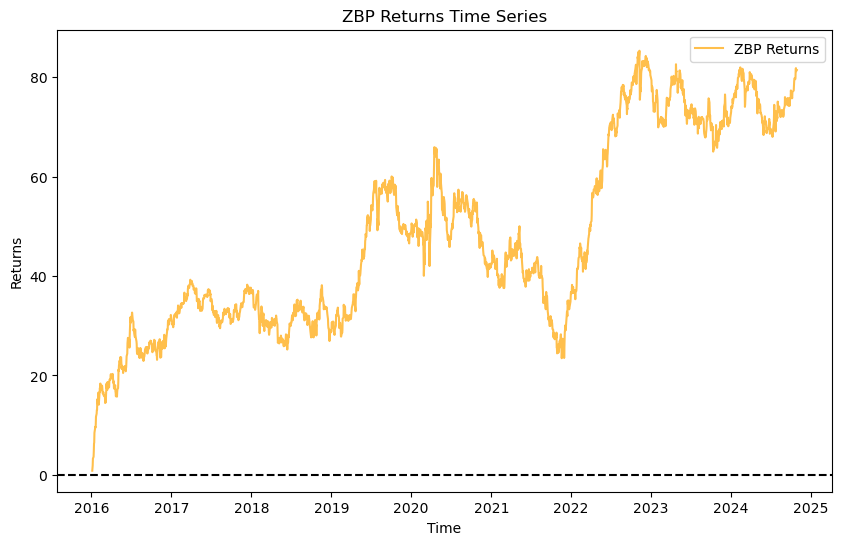

In [12]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(zbp_returns.mul(100).cumsum(), label='ZBP Returns', color='orange', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('ZBP Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [13]:
# Calculate the beta
risk_free_daily = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)

df_regression = pd.DataFrame()
df_regression['y'] = zbp_returns - risk_free_daily
df_regression['x'] = sp500['sp_500'].pct_change(1) - risk_free_daily
df_regression.dropna(inplace = True)
df_regression = df_regression.mul(100)

df_regression

,y,x
Date,,
2016-01-05,0.809189,0.195042
2016-01-06,0.497547,-1.317530
2016-01-07,0.535889,-2.375981
2016-01-08,1.388513,-1.089692
2016-01-11,0.359692,0.079364
...,...,...
2024-10-22,0.285141,-0.058914
2024-10-23,1.700238,-0.930668
2024-10-24,0.204931,0.203122


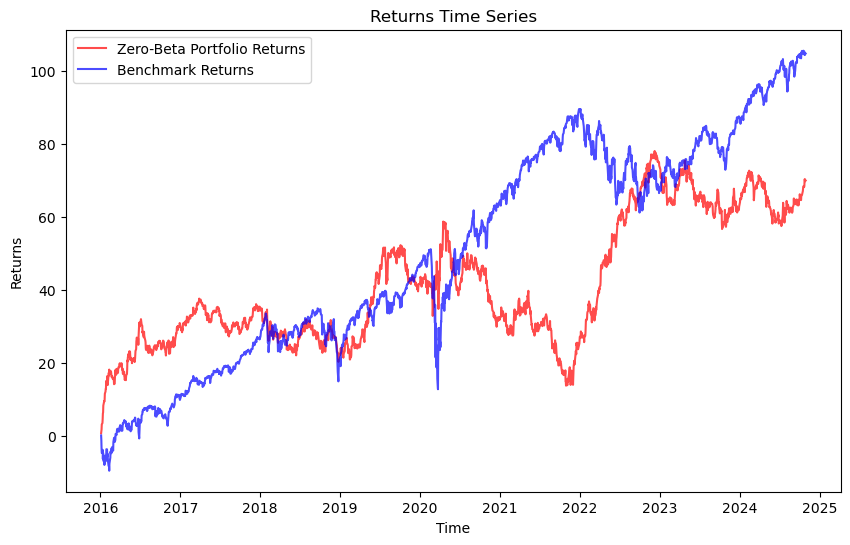

In [14]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(df_regression['y'].cumsum(), label='Zero-Beta Portfolio Returns', color='red', alpha=0.7)
plt.plot(df_regression['x'].cumsum(), label='Benchmark Returns', color='blue', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

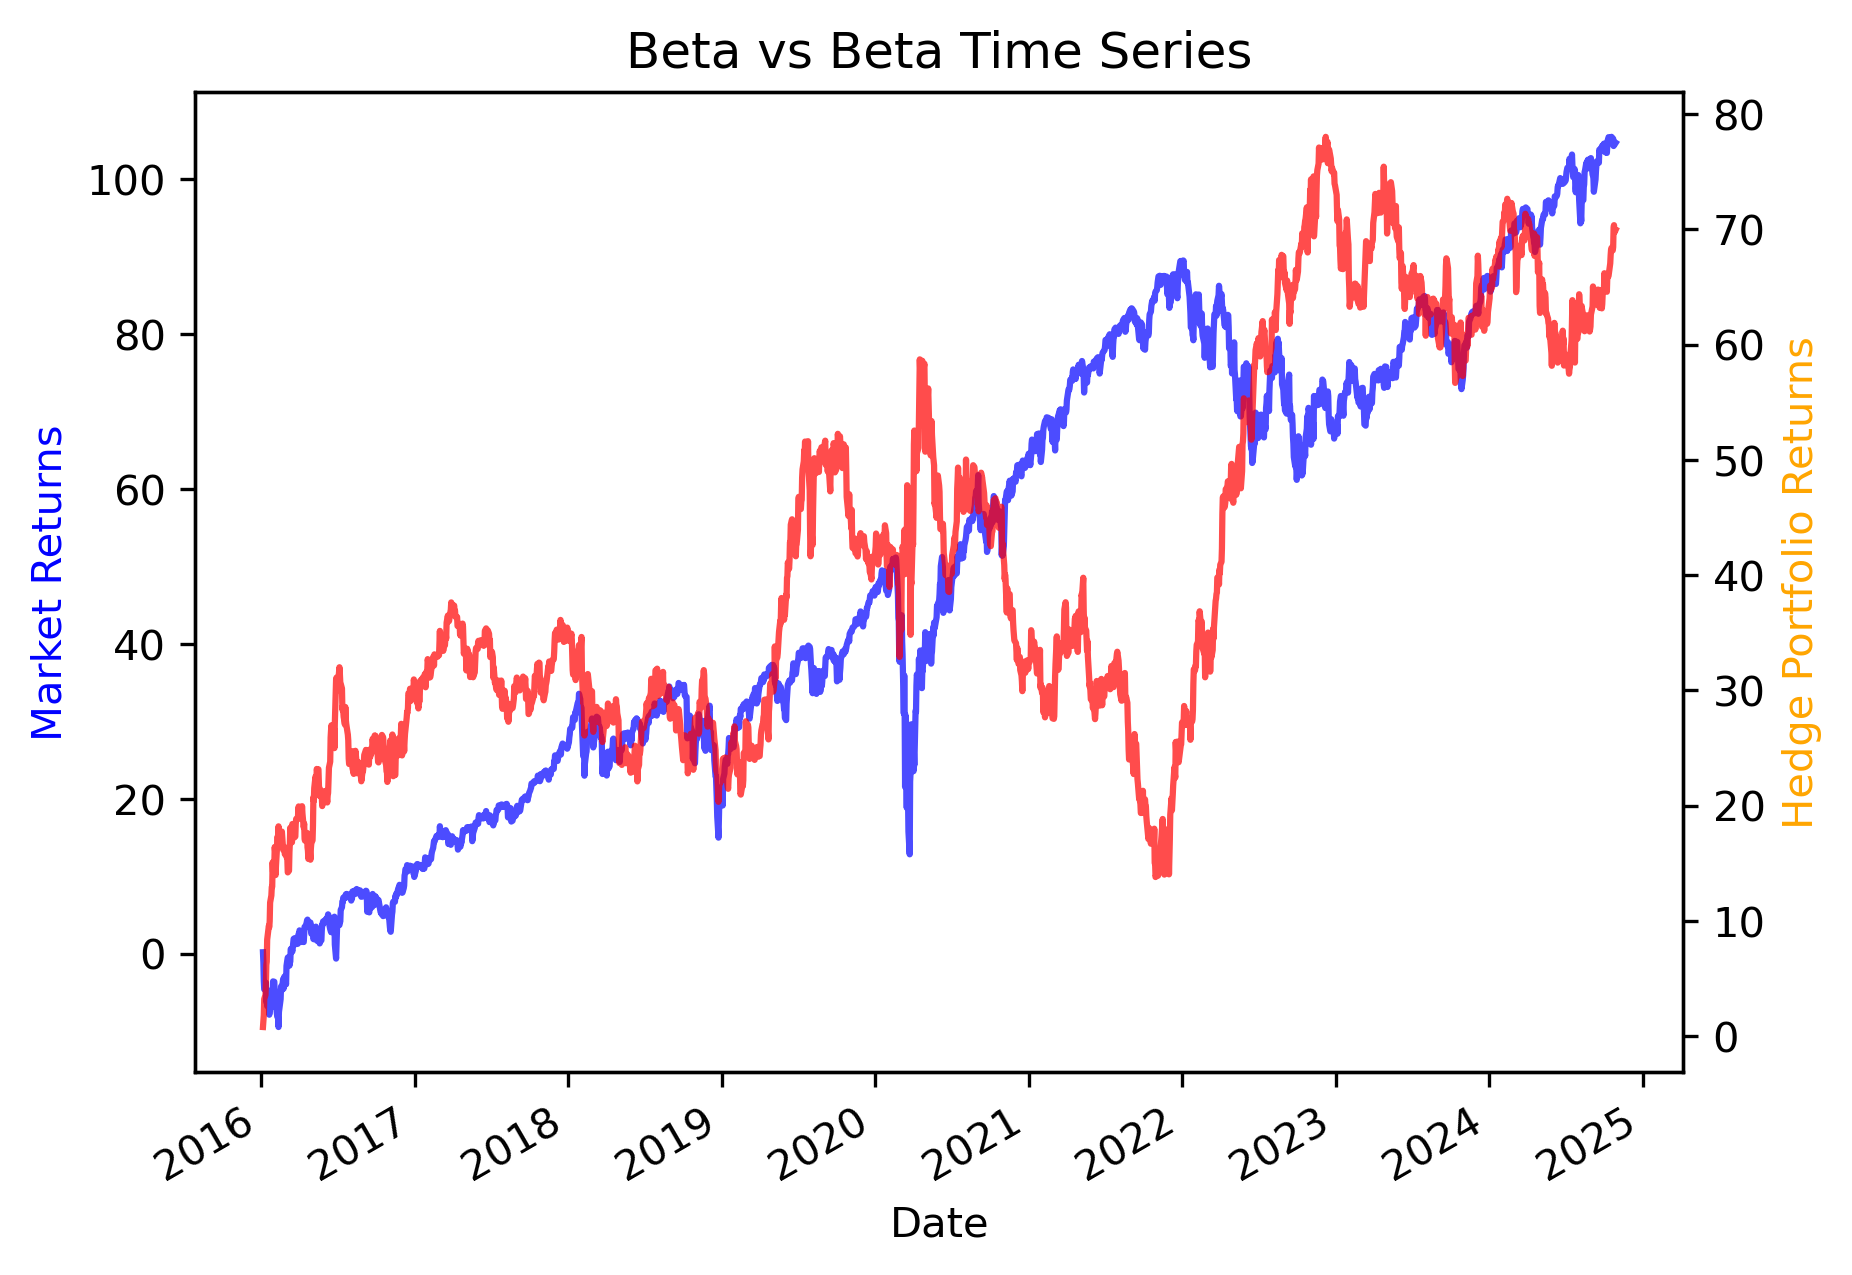

In [15]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
df_regression['x'].cumsum().plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Returns', 
    color='blue'
    )

# ZBP Returns Plot
ax2 = ax1.twinx()

df_regression['y'].cumsum().plot(color = 'red', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Hedge Portfolio Returns', 
    color='orange'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

In [16]:
# Correlation between market and our hedge portfolio

df_regression.corr()

,y,x
y,1.000000,0.079582
x,0.079582,1.000000


In [17]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [18]:
#Model specification
window = len(df_regression)
weights = window * wexp(window, window/2)

model = sm.WLS(
    df_regression['y'], 
    sm.add_constant(df_regression['x']),
    missing='drop',
    weights=weights
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary()) 

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            WLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     13.50
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           0.000244
Time:                        18:46:34   Log-Likelihood:                -3393.0
No. Observations:                2204   AIC:                             6790.
Df Residuals:                    2202   BIC:                             6801.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0256      0.023      1.106      0.2

In [19]:
# Set rolling window size
window = 252
weights = window * wexp(window, window/2)

y = df_regression['y']
x = sm.add_constant(df_regression['x'])

# Lists to store rolling coefficients
params = []
index = []
lower_bounds = []
upper_bounds = []

# Rolling regression
for i in range(window, len(df_regression)):
    Y_window = y.iloc[i - window:i]
    X_window = x.iloc[i - window:i]

    # Fit WLS model
    model = sm.WLS(Y_window, X_window, missing='drop', weights=weights).fit()

    # Store coefficients (const, X1, X2)
    params.append(model.params.values)
    index.append(df_regression.index[i])  # Use the last date of the window

    # Store lower and upper bounds of 95% confidence intervals
    ci = model.conf_int(alpha=0.05)  # 95% CI
    lower_bounds.append(ci.iloc[:, 0].values)  # First column: lower bound
    upper_bounds.append(ci.iloc[:, 1].values)  # Second column: upper bound


In [20]:
# Convert list of coefficients to DataFrame
parameters_df = pd.DataFrame(params, columns=x.columns, index=index)

parameters_df

,const,x
2017-01-06,0.098336,-0.283245
2017-01-09,0.098576,-0.282711
2017-01-10,0.091106,-0.277052
2017-01-11,0.098013,-0.279671
2017-01-12,0.092823,-0.276984
...,...,...
2024-10-22,0.040260,0.009519
2024-10-23,0.041152,0.010318
2024-10-24,0.054995,-0.009000
2024-10-25,0.057142,-0.009258


In [21]:
# Lower bounds DataFrame
lower_df = pd.DataFrame(lower_bounds, columns=[f'{col}_lower' for col in x.columns], index=index)

lower_df

,const_lower,x_lower
2017-01-06,-0.002131,-0.419343
2017-01-09,-0.001581,-0.418662
2017-01-10,-0.009307,-0.414008
2017-01-11,-0.002595,-0.418619
2017-01-12,-0.007524,-0.416169
...,...,...
2024-10-22,-0.083707,-0.144471
2024-10-23,-0.082497,-0.143861
2024-10-24,-0.069488,-0.164236
2024-10-25,-0.067002,-0.164470


In [22]:
# Upper bounds DataFrame
upper_df = pd.DataFrame(upper_bounds, columns=[f'{col}_upper' for col in x.columns], index=index)

upper_df

,const_upper,x_upper
2017-01-06,0.198803,-0.147147
2017-01-09,0.198733,-0.146759
2017-01-10,0.191518,-0.140097
2017-01-11,0.198620,-0.140724
2017-01-12,0.193170,-0.137799
...,...,...
2024-10-22,0.164226,0.163509
2024-10-23,0.164801,0.164497
2024-10-24,0.179478,0.146237
2024-10-25,0.181287,0.145954


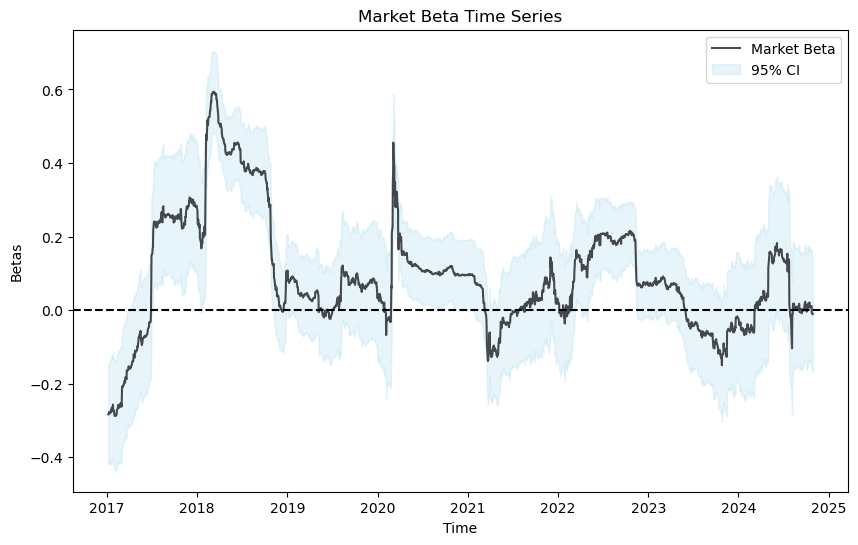

In [23]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(parameters_df['x'], label='Market Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['x_lower'], upper_df['x_upper'], color='skyblue', alpha=0.2, label='95% CI')
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Market Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

In [24]:
zbp_returns.name = 'zero_beta_portfolio'
# zbp_returns.to_csv(r"..\additional_data\zero_beta.csv", header=True)